# Create/Append HDF5 dataset

References:
* http://docs.h5py.org/en/latest/quick.html
* http://docs.h5py.org/en/latest/high/file.html
* http://docs.h5py.org/en/latest/high/dataset.html?highlight=create_dataset
* http://docs.h5py.org/en/latest/high/group.html?highlight=get
* http://stackoverflow.com/questions/11753418/check-if-node-exists-in-h5py
* http://stackoverflow.com/questions/16213525/updating-h5py-datasets
* http://stackoverflow.com/questions/25655588/incremental-writes-to-hdf5-with-h5py
* http://stackoverflow.com/questions/22998248/how-to-resize-an-hdf5-array-with-h5py/26208582

In [1]:
import h5py
import numpy as np
import scipy.misc
import random
import matplotlib.pyplot as plt

### Read dataset directory

In [2]:
# Lists to hold image filename and label
xs = []
ys = []

with open("driving_dataset/data.txt") as f:
    for line in f:
        # Image path
        xs.append("driving_dataset/" + line.split()[0])        
        # Steering wheel label
        ys.append(float(line.split()[1]))

num_images = len(xs)
print("Number of images: %d" % num_images)

# Use zip to create a list with images/labels
c = list(zip(xs, ys))
#random.shuffle(c)
xs, ys = zip(*c)

Number of images: 820


### Load images into memory(as ndarray)

In [3]:
list_imgs_ndarray = []
list_lables_ndarray = []
for imPath in xs:
    image = scipy.misc.imread(imPath, mode="RGB")
    list_imgs_ndarray.append(image)

# Convert list to ndarray
list_imgs_ndarray = np.asarray(list_imgs_ndarray)
list_labels_ndarray = np.asarray(ys)

# Just print to debug
print(list_imgs_ndarray.shape)
print(list_labels_ndarray.shape)

(820, 256, 256, 3)
(820,)


## Create hdf5 dataset

In [4]:
file = h5py.File ('DrivingData.h5', 'w') # 'a' is append

# Create Training group
group = file.create_group("Train")

# Create Label dataset and populate. Default data is float
# Dataset must be resizable and chunked
dataset_label = group.create_dataset("Labels", list_labels_ndarray.shape, maxshape=(None,), chunks=True)
dataset_label[...] = list_labels_ndarray

# Create Image dataset and populate
dataset_imgs = group.create_dataset("Images", list_imgs_ndarray.shape, maxshape=(None,256,256,3), chunks=True)
dataset_imgs[...] = list_imgs_ndarray

# Close and save data
file.flush()
file.close()

## Append more information on dataset

In [5]:
file = h5py.File ('DrivingData.h5', 'a')

# Check if the dataset exist
existTrain = "/Train/Labels" in file

if existTrain:
    # Initialize pre-existing datasets
    dataset_imgs = file["/Train/Images"]
    dataset_label = file["/Train/Labels"]

    # Get old sizes
    old_size_imgs = dataset_imgs.shape[0]
    old_size_labels = dataset_label.shape[0]

### Resize datasets

In [6]:
# Resize datasets
dataset_imgs.resize(old_size_imgs + num_images,0)
dataset_label.resize(old_size_imgs + num_images,0)

### Append data to the end of the dataset

In [7]:
# Don't forget that on python the indexes start at zero
dataset_label[old_size_imgs:old_size_imgs+num_images] = list_labels_ndarray
dataset_imgs[old_size_imgs:old_size_imgs+num_images,:,:,:] = list_imgs_ndarray

### Select some element and display

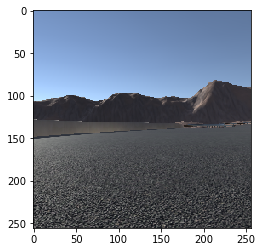

Wheel data: 0.139580


In [8]:
wheel = dataset_label[313]
img = dataset_imgs[313,:,:,:]
plt.imshow(np.uint8(img))
plt.show()
print("Wheel data: %f" % wheel)

## Close and save data

In [9]:
file.flush()
file.close()